## **Importing Independences**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

## **Creating a base directory**

In [2]:
base_dir = '/kaggle/input/fruit-and-vegetable-image-recognition'

In [3]:
train_path = os.path.join(base_dir, 'train')
test_path = os.path.join(base_dir, 'test')
validation_path = os.path.join(base_dir, 'validation')

## **Image visualization from Dataset**

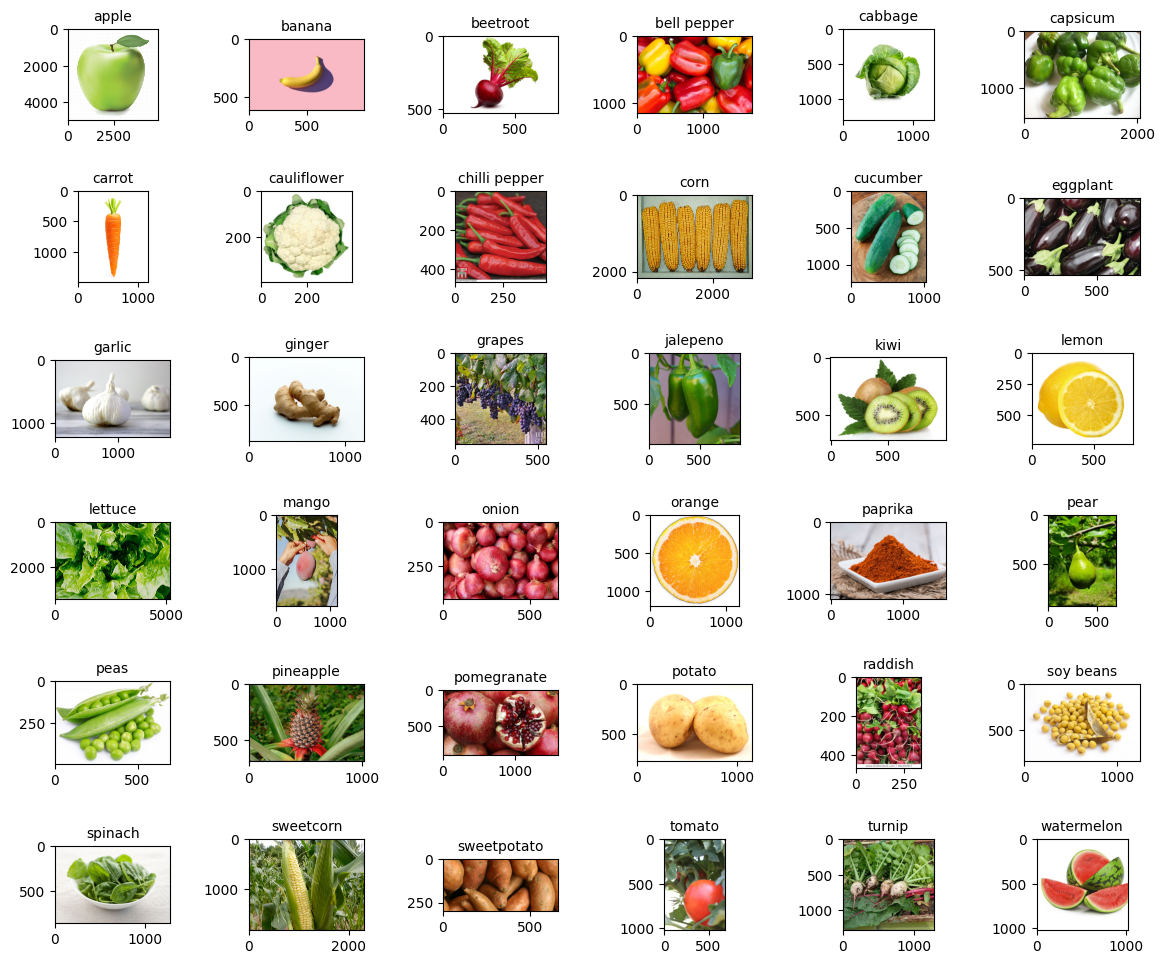

In [4]:
categories = sorted(os.listdir(train_path))

# Initialize list for sample images
sample_images = []
for category in categories:
    category_path = os.path.join(train_path, category)  # Path to the category folder
    first_image = os.listdir(category_path)[0]  # Get the first image in the folder
    sample_images.append(os.path.join(category_path, first_image))  # Full path to the image

# (6x6) grid to plot the images
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(12, 10))

for ax, img_path, label in zip(axes.flat, sample_images, categories):
    ax.imshow(plt.imread(img_path))  # Display the image
    ax.set_title(label, fontsize=10)  # title for each image

# Adjust layout
plt.tight_layout(pad=2)
plt.show()

## **Checking the Number of Images per classes**

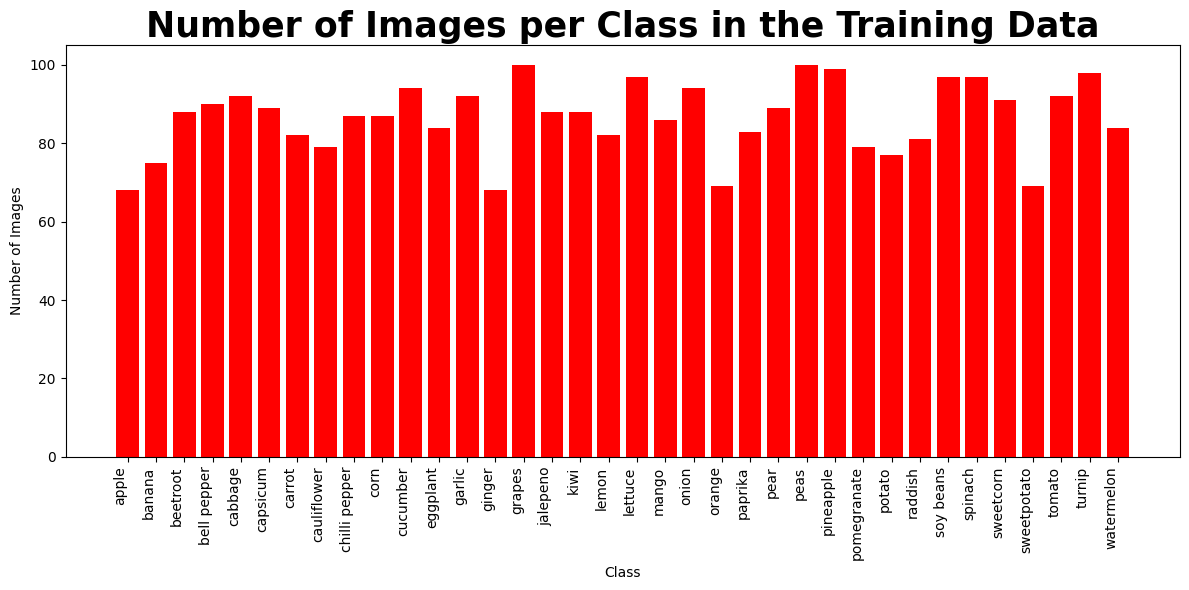

In [5]:
# Get the list of all subdirectories (categories/classes)
classes = sorted(os.listdir(train_path))  # Sorting for consistency in display

# Count the number of images in each class
image_count = {}
for cls in classes:
    class_path = os.path.join(train_path, cls)
    image_count[cls] = len(os.listdir(class_path))

# Create a bar plot for image counts
plt.figure(figsize=(12, 6))
plt.bar(image_count.keys(), image_count.values(), color='red')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in the Training Data' , fontsize=25, fontweight='bold')
plt.xticks(rotation=90, ha='right')  # Rotate class names for better readability
plt.tight_layout()  # Ensure everything fits
plt.show()

## **Loading the data through Batches**

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                               image_size=(224, 224),
                                                              batch_size=32,
                                                                    seed=42)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_path,
                                                              image_size=(224, 224),
                                                              batch_size=32,
                                                                 seed = 42)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


In [8]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the base model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  
output = Dense(36, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 11,186,259 (42.67 MB)

 Trainable params: 402,724 (1.54 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

## **Making a CNN model**

## **Callback Initialization**

In [11]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",        # Monitor validation loss
        patience=5,               # Stop after 5 epochs without improvement
        restore_best_weights=True # Restore the best model weights
    )
]

## **Time to train the model**

In [12]:
history = model.fit(
    train_dataset,             
    epochs=100,                
    validation_data=val_dataset,
    callbacks=callbacks,       
    # class_weight=class_weights,
    verbose=1                   
)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 93s 626ms/step - accuracy: 0.1343 - loss: 3.3706 - val_accuracy: 0.7009 - val_loss: 2.3574
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.5721 - loss: 2.2657 - val_accuracy: 0.8006 - val_loss: 1.3276
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.6993 - loss: 1.4722 - val_accuracy: 0.8462 - val_loss: 0.8246
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step - accuracy: 0.7468 - loss: 1.0775 - val_accuracy: 0.8860 - val_loss: 0.6067
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.7736 - loss: 0.8950 - val_accuracy: 0.8889 - val_loss: 0.4929
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 285ms/step - accuracy: 0.7920 - loss: 0.7841 - val_accuracy: 0.8974 - val_loss: 0.4225
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 287ms/step - accuracy: 0.8193 - loss: 0.6811 - val_accuracy: 0.9145 - val_loss: 0.3747
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 291ms/step - accuracy: 0.8193 - loss: 0.6330 - 

## **Plotting the accuracy and the loss**

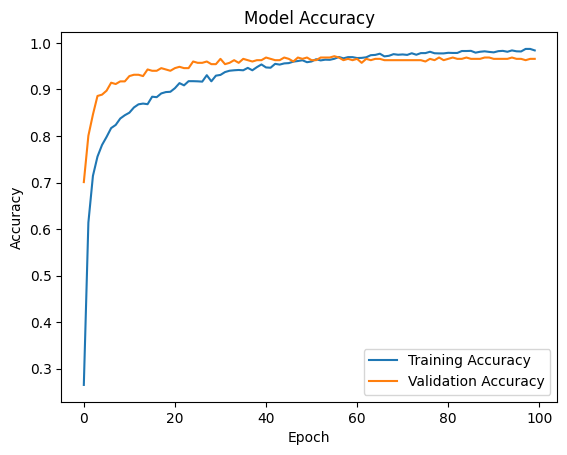

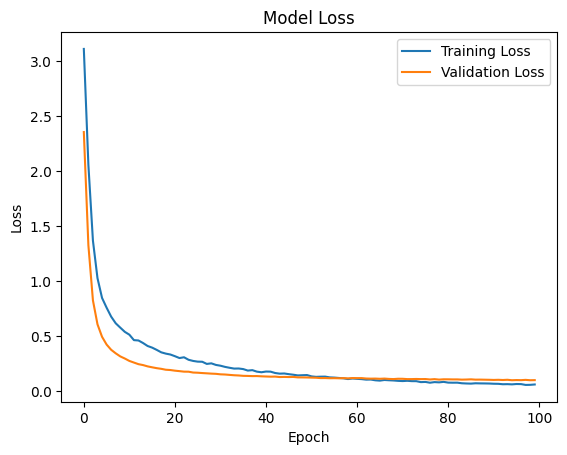

In [13]:
# Plot training & validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## **Loading the Test Dataset**

In [14]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,  # Path to the test dataset
    image_size=(224, 224),
    batch_size=32,
    seed=42
)

Found 359 files belonging to 36 classes.


## **Evaluating the model on the test dataset**

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the test accuracy and loss
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 899ms/step - accuracy: 0.9706 - loss: 0.0848
Test Loss: 0.09568137675523758
Test Accuracy: 0.9665738344192505


In [19]:
model.save('efficient_model.h5')

In [17]:
import sys
import matplotlib
import sklearn

# Print Python version
print(f"Python Version: {sys.version}")

# Print library versions
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")

Python Version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
NumPy Version: 1.26.4
Pandas Version: 2.2.3
Matplotlib Version: 3.7.5
TensorFlow Version: 2.17.1
Scikit-learn Version: 1.2.2


In [18]:
class_labels = train_dataset.class_names
print(class_labels)


['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
